# Exploring your TroveHarvester data

<div class="alert alert-block alert-warning">
    <b>Under construction</b>
</div>

In [1]:
import os
import pandas as pd # makes manipulating the data easier
# import plotly.offline as py # for charts
# import plotly.graph_objs as go
import altair as alt

# py.init_notebook_mode() # initialise plotly
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
# Import a harvest zip file you've created previously
# First upload the zip file to the data directory, then run this cell
import zipfile
for zipped in [z for z in os.listdir('data') if z[-4:] == '.zip']:
    with zipfile.ZipFile(os.path.join('data', zipped), 'r') as zip_file:
        zip_file.extractall(os.path.join('data', zipped[:-4]))

In [5]:
def get_latest_harvest():
    '''
    Get the timestamp of the most recent harvest.
    '''
    harvests = sorted([d for d in os.listdir('data') if os.path.isdir(os.path.join('data', d))])
    return harvests[-1]

In [6]:
def open_harvest_data(timestamp=None):
    '''
    Open the results of the specified harvest (most recent by default).
    
    Returns a DataFrame.
    '''
    if not timestamp:
        timestamp = get_latest_harvest()
    print(timestamp)
    df = pd.read_csv(os.path.join('data', timestamp, 'results.csv'), parse_dates=['date'])
    return df  

In [7]:
df = open_harvest_data()

1536200911


In [8]:
# Let's have a look!
df['date'].describe()

count                    2714
unique                   1895
top       1902-01-18 00:00:00
freq                       14
first     1860-12-24 00:00:00
last      2005-07-01 00:00:00
Name: date, dtype: object

## Show the most common newspapers

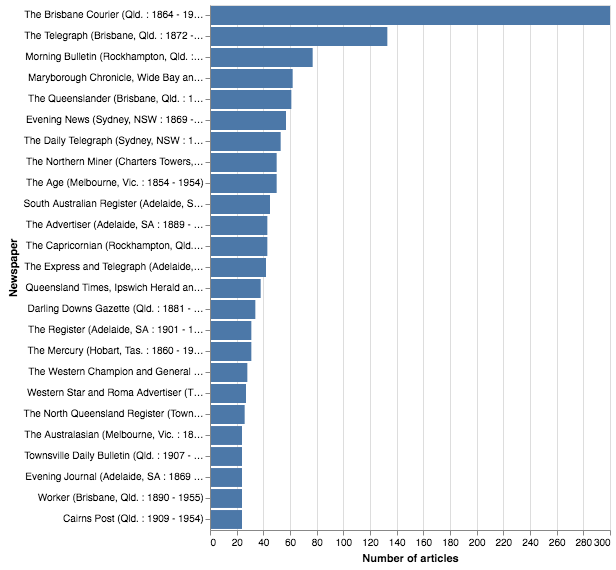

In [30]:
alt.Chart(df).mark_bar().encode(
    x=alt.X('count:Q', title='Number of articles'),
    y=alt.Y('newspaper_title:N', title='Newspaper', sort=alt.EncodingSortField(field='count', order='descending', op='sum')),
    tooltip=[alt.Tooltip('newspaper_title:N', title='Newspaper'), alt.Tooltip('count:Q', title='Articles')]
).transform_aggregate(
    count='count()',
    groupby=['newspaper_title']
).transform_window(
    window=[{'op': 'rank', 'as': 'rank'}],
    sort=[{'field': 'count', 'order': 'descending'}]
).transform_filter('datum.rank <= 25')

## Show when the articles were published

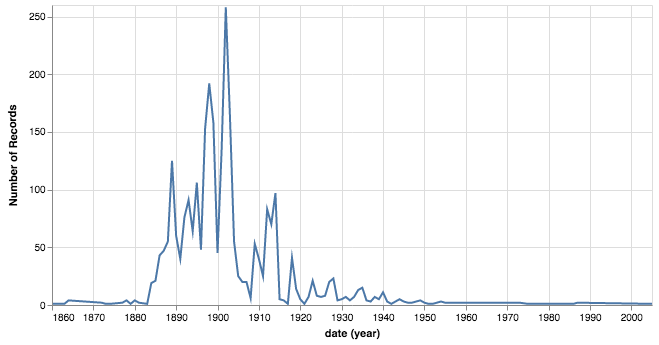

In [36]:
alt.Chart(df).mark_line().encode(
    x='year(date):T',
    y='count()',
    tooltip=[alt.Tooltip('year(date):T', title='Year'), alt.Tooltip('count()', title='Articles')]
).properties(width=600)

## Find the longest article

In [ ]:
# Which is the longest article(s)?
df[df['words'] == df['words'].max()]

In [ ]:
df.loc[df['title'].str.contains('protest', case=False, na=False)]

## Make a simple word cloud

In [ ]:
df_titles = df[(df['title'] != 'No Title') & (df['title'] != 'Advertising')]
# Get all the articles titles and turn them into a single string
title_text = df_titles['title'].str.lower().str.cat(sep=' ').replace('advertising', '').replace('no title', '')

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800).generate(title_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Using TextBlob

In [ ]:
from textblob import TextBlob
from operator import itemgetter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
blob = TextBlob(title_text)
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
word_counts = [[word, count] for word, count in blob.lower().word_counts.items() if word not in stopwords]
word_counts = sorted(word_counts, key=itemgetter(1), reverse=True)[:25]
pd.DataFrame(word_counts).style.format({1: '{:,}'}).bar(subset=[1], color='#d65f5f').set_properties(subset=[1], **{'width': '300px'})

## Mapping newspaper locations

This makes use of a spreadsheet file that maps Trove newspaper titles to locations. Once we've loaded the spreadsheet we can use it to locate all of the harvested articles.

In [ ]:
# Url of the Trove places spreadshseet
trove_places = 'https://docs.google.com/spreadsheets/d/1rURriHBSf3MocI8wsdl1114t0YeyU0BVSXWeg232MZs/gviz/tq?tqx=out:csv&sheet=198244298'

# Open the CSV file with Pandas
place_df = pd.read_csv(trove_places)

In [ ]:
# We're going to map the locations using ipyleaflet, a Python implementation of the popular Leaflet javascript library.
# Let's import what we need.
from ipyleaflet import Map, Marker, MarkerCluster

# Create the map
m = Map(center=(-28, 140), zoom=4)

# Loop through the results creating a marker for each article
markers = []
for row in df.itertuples(index=False):
    try:
        # Look up the newspaper identifier in the locations spreadsheet
        location = place_df.loc[place_df['title_id'] == row.newspaper_id].iloc[0]
    except IndexError:
        # There are Government Gzettes
        print('Not found: {}'.format(row.newspaper_id))
    marker = Marker(location=(float(location['latitude']), float(location['longitude'])))
    markers.append(marker)

marker_cluster = MarkerCluster(
    markers=markers
)

m.add_layer(marker_cluster);
m

----

Created by [Tim Sherrratt](https://timsherratt.org) ([@wragge](https://twitter.com/wragge)) as part of the [OzGLAM workbench](https://github.com/wragge/ozglam-workbench).

If you think this project is worthwhile you can [support it on Patreon](https://www.patreon.com/timsherratt).